       time      sc1      sc2      sc3      sc4      sc5      sc6      sc7  \
0  0.014737  9.80748  9.80748  9.80748  9.80748  9.80748  9.80748  9.80748   
1  0.029474  9.80748  9.80748  9.80748  9.80748  9.80748  9.80748  9.80748   
2  0.044212  9.80748  9.80748  9.80748  9.80748  9.80748  9.80748  9.80748   
3  0.058949  9.80748  9.80748  9.80748  9.80748  9.80748  9.80748  9.80748   
4  0.073686  9.80748  9.80748  9.80748  9.80748  9.80748  9.80748  9.80748   

       sc8      sc9  ...    sc311    sc312    sc313    sc314    sc315  \
0  9.80748  9.80748  ...  9.80748  9.80748  9.80748  9.80748  9.80748   
1  9.80748  9.80748  ...  9.80748  9.80748  9.80748  9.80748  9.80748   
2  9.80748  9.80748  ...  9.80748  9.80748  9.80748  9.80748  9.80748   
3  9.80748  9.80748  ...  9.80748  9.80748  9.80748  9.80748  9.80748   
4  9.80748  9.80748  ...  9.80748  9.80748  9.80748  9.80748  9.80748   

     sc316    sc317    sc318    sc319    sc320  
0  9.80748  9.80748  9.80748  9.80748  9.80

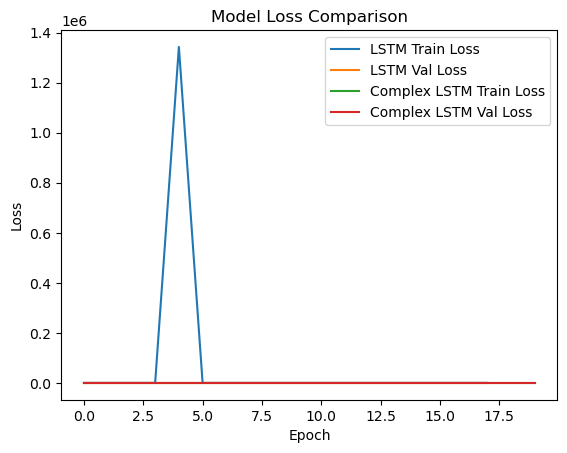

2/2 [==============================] - 0s 22ms/step


ValueError: Input contains NaN.

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load data
data_path = "C:\\Users\\elmoe\\Desktop\\decision tree\\decision making\\sim3_rakata_6(320sc).xlsx"
df = pd.read_excel(data_path)

# Display the first few rows of the dataframe to understand its structure
print(df.head())

# Assuming first column is 'time' and the rest are the scenarios
time = df.iloc[:, 0].values
scenarios = df.iloc[:, 1:].values

# Normalize the scenarios
scaler = MinMaxScaler()
normalized_scenarios = scaler.fit_transform(scenarios)

# Combine the time and normalized scenarios for further processing
data_normalized = np.column_stack((time, normalized_scenarios))

# Function to create sequences
def create_short_sequences(data, seq_lengths, time_interval):
    sequences = {}
    for length in seq_lengths:
        num_steps = length * time_interval  # Convert time to number of steps
        seq_data = []
        for col in range(1, data.shape[1]):  # Iterate over each scenario column
            seq = data[:num_steps, col]
            seq_data.append(seq)
        sequences[length] = np.array(seq_data)
    return sequences

# Assuming data is recorded every second
time_interval = 60  # in seconds (1 minute = 60 seconds)
seq_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # lengths in minutes

# Create sequences
short_sequences = create_short_sequences(data_normalized, seq_lengths, time_interval)

# Example using sequences of 5 minutes
seq_length = 5  # for example, we are using 5 minutes
X = short_sequences[seq_length][:, :-1]
y = short_sequences[seq_length][:, -1]

# Check for NaN values and remove them
X = np.nan_to_num(X)
y = np.nan_to_num(y)

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the prepared data
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

# Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))  # Output layer for prediction
    model.compile(optimizer='adam', loss='mse')
    return model

# Build a more complex LSTM model
def build_complex_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for prediction
    model.compile(optimizer='adam', loss='mse')
    return model

# Define input shape
input_shape = (X_train.shape[1], 1)  # 29 timesteps, 1 feature per timestep

# Build and train the initial LSTM model
model = build_lstm_model(input_shape)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_val_reshaped, y_val))

# Build and train the complex LSTM model
complex_lstm_model = build_complex_lstm_model(input_shape)
history_complex_lstm = complex_lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_val_reshaped, y_val))

# Evaluate the models on the validation data
val_loss = model.evaluate(X_val_reshaped, y_val)
val_loss_complex_lstm = complex_lstm_model.evaluate(X_val_reshaped, y_val)
print(f'Validation Loss (LSTM): {val_loss}')
print(f'Validation Loss (Complex LSTM): {val_loss_complex_lstm}')

# Plot training & validation loss values for all models
plt.plot(history.history['loss'], label='LSTM Train Loss')
plt.plot(history.history['val_loss'], label='LSTM Val Loss')
plt.plot(history_complex_lstm.history['loss'], label='Complex LSTM Train Loss')
plt.plot(history_complex_lstm.history['val_loss'], label='Complex LSTM Val Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Make predictions and evaluate model performance
def evaluate_model(model, X_val_reshaped, y_val):
    y_pred = model.predict(X_val_reshaped).reshape(-1)
    y_val = y_val.reshape(-1)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return mse, mae, r2, y_pred

mse, mae, r2, y_pred = evaluate_model(model, X_val_reshaped, y_val)
mse_complex_lstm, mae_complex_lstm, r2_complex_lstm, y_pred_complex_lstm = evaluate_model(complex_lstm_model, X_val_reshaped, y_val)

print(f'LSTM - MSE: {mse}, MAE: {mae}, R² Score: {r2}')
print(f'Complex LSTM - MSE: {mse_complex_lstm}, MAE: {mae_complex_lstm}, R² Score: {r2_complex_lstm}')

# Plot true vs predicted values for comparison
plt.figure(figsize=(10, 5))
plt.plot(y_val, label='True Values')
plt.plot(y_pred, label='LSTM Predictions')
plt.plot(y_pred_complex_lstm, label='Complex LSTM Predictions')
plt.title('True vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Wave Height')
plt.legend()
plt.show()

# Export metrics to Excel
metrics_df = pd.DataFrame({
    'Model': ['LSTM', 'Complex LSTM'],
    'MSE': [mse, mse_complex_lstm],
    'MAE': [mae, mae_complex_lstm],
    'R² Score': [r2, r2_complex_lstm]
})
metrics_df.to_excel('model_metrics_comparison.xlsx', index=False)
print('Metrics saved to model_metrics_comparison.xlsx')

# Function to test the model with short-time observations
def test_short_time_observations(model, data_normalized, time_interval, short_durations):
    results = []
    for duration in short_durations:
        num_steps = duration * time_interval
        short_time_data = data_normalized[:num_steps, 1:]
        short_time_data_reshaped = short_time_data.reshape((short_time_data.shape[1], num_steps, 1))

        # Make predictions
        y_short_pred = model.predict(short_time_data_reshaped)
        y_short_pred = y_short_pred.reshape(-1)
        
        # Evaluate performance
        y_true = data_normalized[num_steps-1, 1:]
        mse = mean_squared_error(y_true, y_short_pred)
        mae = mean_absolute_error(y_true, y_short_pred)
        r2 = r2_score(y_true, y_short_pred)

        print(f'Duration: {duration} minutes')
        print(f'MSE: {mse}')
        print(f'MAE: {mae}')
        print(f'R² Score: {r2}')
        
        # Save results to a list
        results.append({'Duration (Minutes)': duration, 'MSE': mse, 'MAE': mae, 'R² Score': r2})
        
        # Plot true vs predicted values
        plt.figure(figsize=(10, 5))
        plt.plot(y_true, label='True Values')
        plt.plot(y_short_pred, label='Predicted Values')
        plt.title(f'True vs Predicted Values ({duration} Minutes)')
        plt.xlabel('Samples')
        plt.ylabel('Wave Height')
        plt.legend()
        plt.show()
        
        # Plot short-time observation input for one significant scenario
        plt.figure(figsize=(10, 5))
        plt.plot(short_time_data[:, 0], label=f'Input')
        plt.title(f'Short-Time Observation Input for one test scenario ({duration} Minutes)')
        plt.xlabel('Time Steps')
        plt.ylabel('Wave Height')
        plt.legend(loc='upper right')
        plt.show()
    
    return results

# Test the model with short-time observations
short_obs_results_lstm = test_short_time_observations(model, data_normalized, time_interval, seq_lengths)
short_obs_results_complex_lstm = test_short_time_observations(complex_lstm_model, data_normalized, time_interval, seq_lengths)

# Save short observation results to Excel
short_obs_df_lstm = pd.DataFrame(short_obs_results_lstm)
short_obs_df_complex_lstm = pd.DataFrame(short_obs_results_complex_lstm)

with pd.ExcelWriter('short_observation_metrics.xlsx') as writer:
    short_obs_df_lstm.to_excel(writer, sheet_name='LSTM', index=False)
    short_obs_df_complex_lstm.to_excel(writer, sheet_name='Complex LSTM', index=False)
print('Short observation metrics saved to short_observation_metrics.xlsx')

# Save model summary for comparison
model_summary = {
    'Model': ['LSTM', 'Complex LSTM'],
    'Layers': [
        'LSTM(50) -> Dense(1)',
        'LSTM(50) -> Dropout(0.2) -> LSTM(50) -> Dropout(0.2) -> LSTM(50) -> Dropout(0.2) -> Dense(1)'
    ]
}
model_summary_df = pd.DataFrame(model_summary)
with pd.ExcelWriter('model_comparison_summary.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
    model_summary_df.to_excel(writer, sheet_name='Model Summary', index=False)
print('Model summary saved to model_comparison_summary.xlsx')

Epoch 1/20
8/8 [==============================] - 2s 120ms/step - loss: 0.4128 - val_loss: 0.3447
Epoch 2/20
8/8 [==============================] - 1s 86ms/step - loss: 0.2987 - val_loss: 0.2388
Epoch 3/20
8/8 [==============================] - 1s 86ms/step - loss: 0.1947 - val_loss: 0.1290
Epoch 4/20
8/8 [==============================] - 1s 84ms/step - loss: 0.0805 - val_loss: 0.0142
Epoch 5/20
8/8 [==============================] - 1s 93ms/step - loss: 0.0244 - val_loss: 0.0196
Epoch 6/20
8/8 [==============================] - 1s 80ms/step - loss: 0.0323 - val_loss: 0.0374
Epoch 7/20
8/8 [==============================] - 1s 81ms/step - loss: 0.0426 - val_loss: 0.0397
Epoch 8/20
8/8 [==============================] - 1s 76ms/step - loss: 0.0412 - val_loss: 0.0352
Epoch 9/20
8/8 [==============================] - 1s 90ms/step - loss: 0.0354 - val_loss: 0.0287
Epoch 10/20
8/8 [==============================] - 1s 81ms/step - loss: 0.0286 - val_loss: 0.0225
Epoch 11/20
8/8 [===========

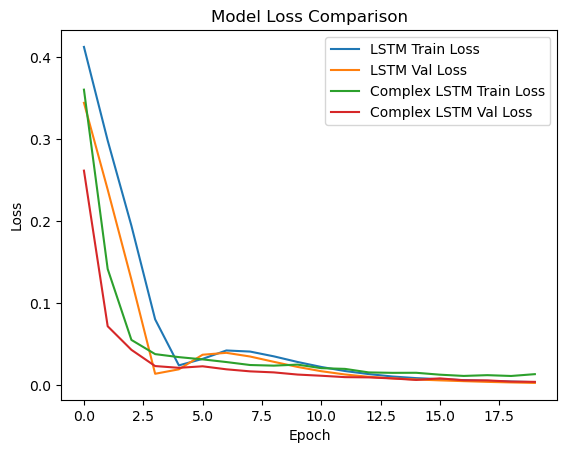

2/2 [==============================] - 0s 94ms/step
LSTM - MSE: 0.0153468240116155, MAE: 0.09654143535167362, R² Score: 0.9616835652359464
Complex LSTM - MSE: 0.02199122931043491, MAE: 0.12099331103182373, R² Score: 0.9450944701902578


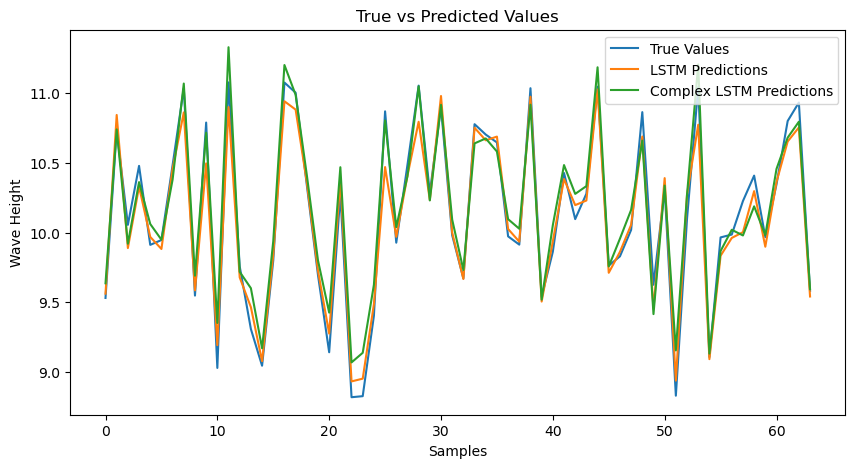

10/10 [==============================] - 0s 7ms/step
Duration: 1 minutes
MSE: 0.06388322699742692
MAE: 0.19749958679986185
R² Score: -0.3099310724520745


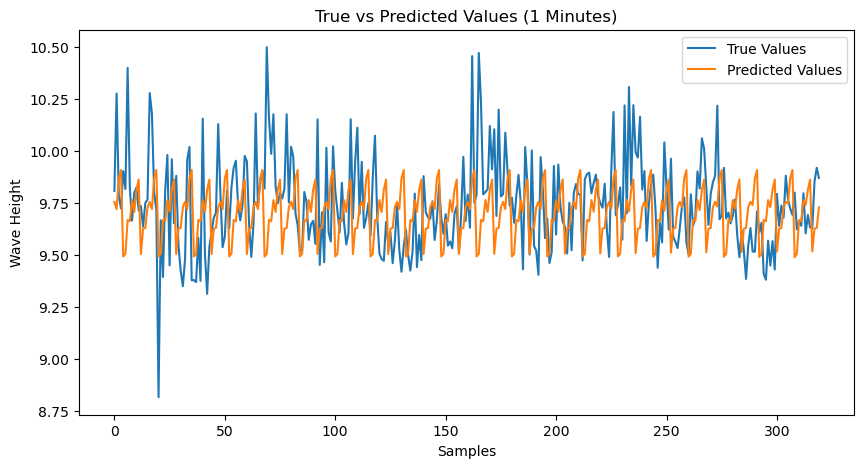

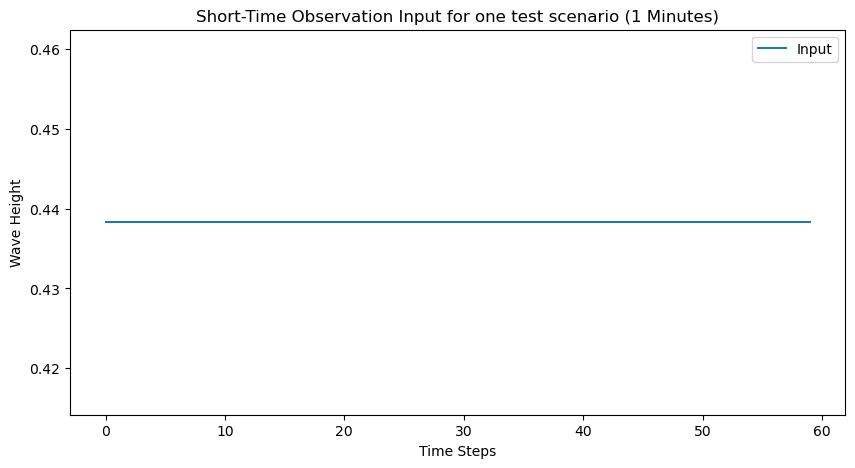

10/10 [==============================] - 0s 12ms/step
Duration: 2 minutes
MSE: 0.24526825664643398
MAE: 0.3561728984364666
R² Score: -0.27295582391972584


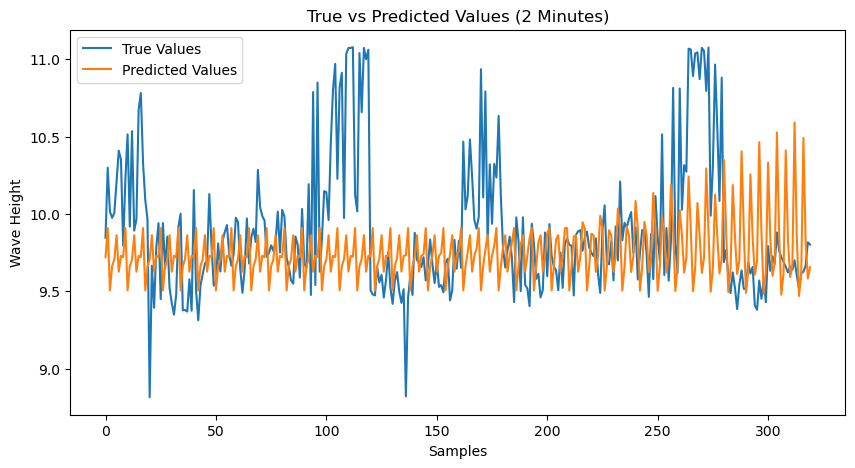

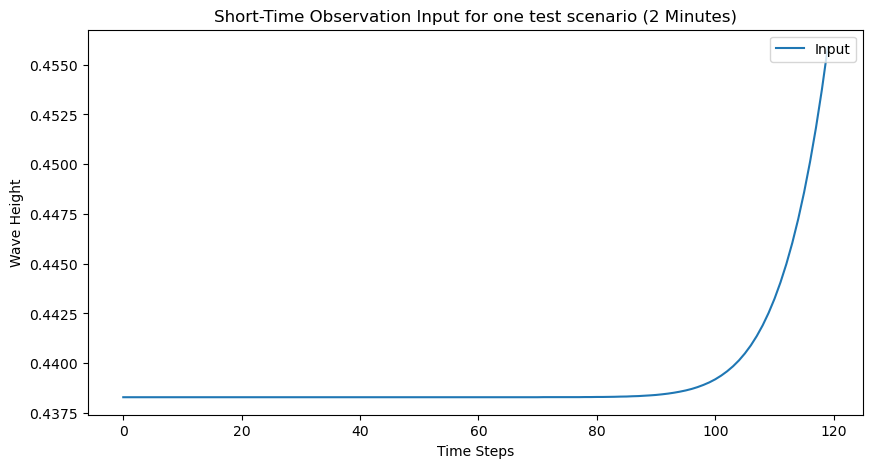

10/10 [==============================] - 0s 17ms/step
Duration: 3 minutes
MSE: 0.5285608195221869
MAE: 0.5829874872051282
R² Score: -0.14752346275368167


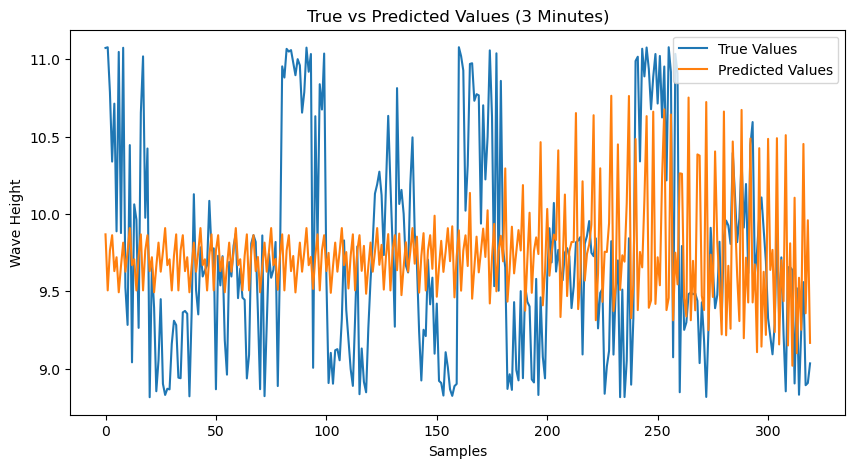

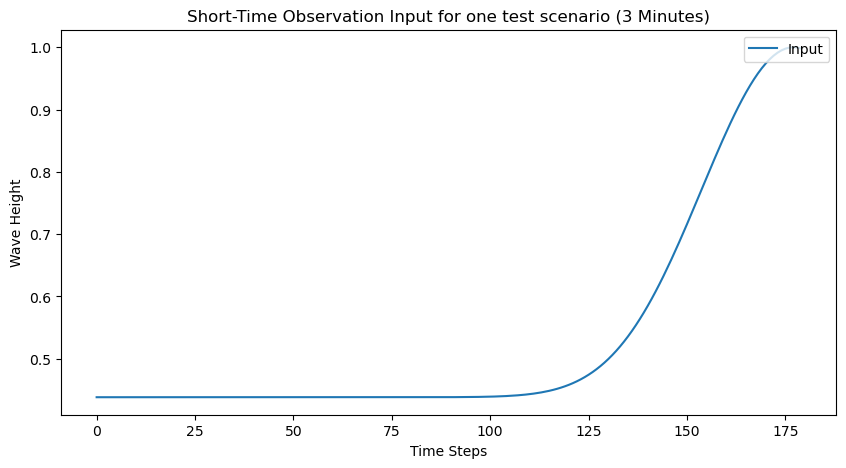

10/10 [==============================] - 0s 23ms/step
Duration: 4 minutes
MSE: 0.6236013257877036
MAE: 0.6428937136021735
R² Score: -0.2889287374393843


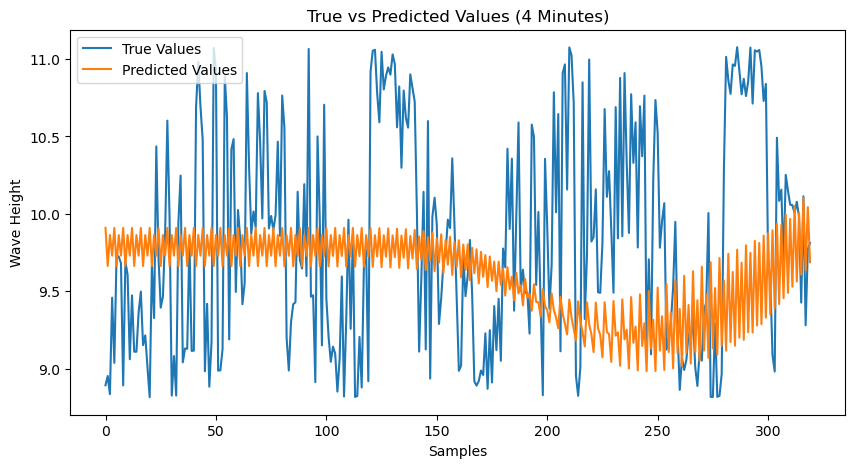

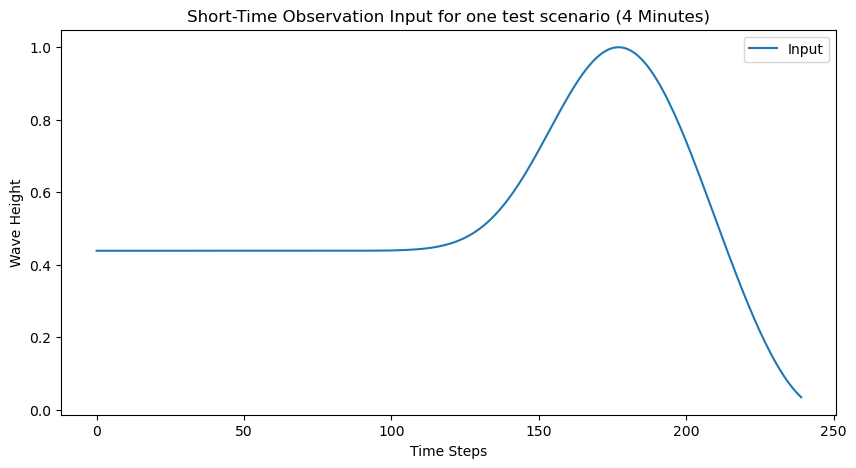

10/10 [==============================] - 0s 28ms/step
Duration: 5 minutes
MSE: 0.715590530470623
MAE: 0.6645398211756829
R² Score: -0.7888397644713068


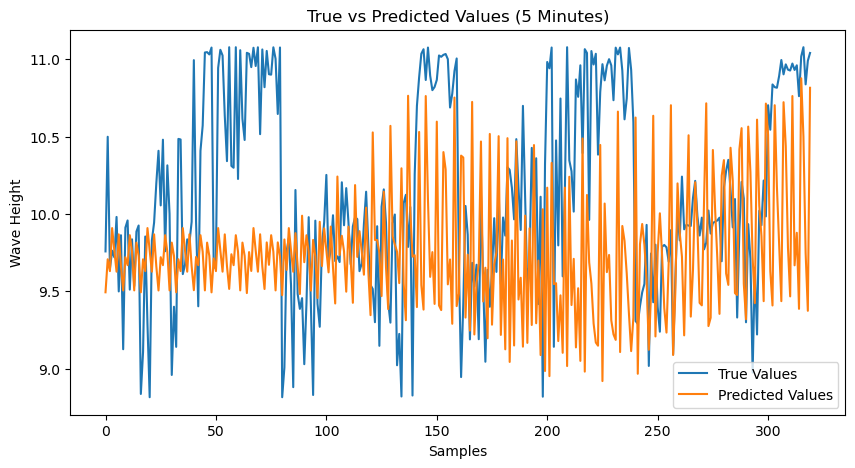

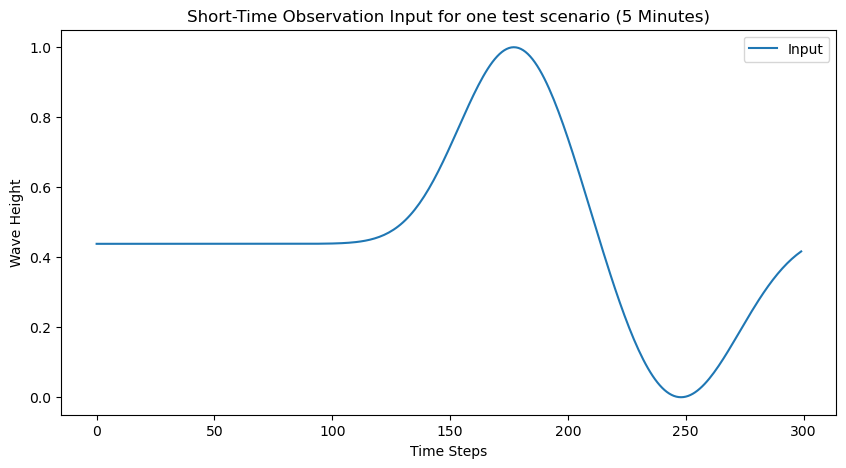

10/10 [==============================] - 0s 35ms/step
Duration: 6 minutes
MSE: 0.609295579298242
MAE: 0.6282570554414233
R² Score: -0.9352086823507719


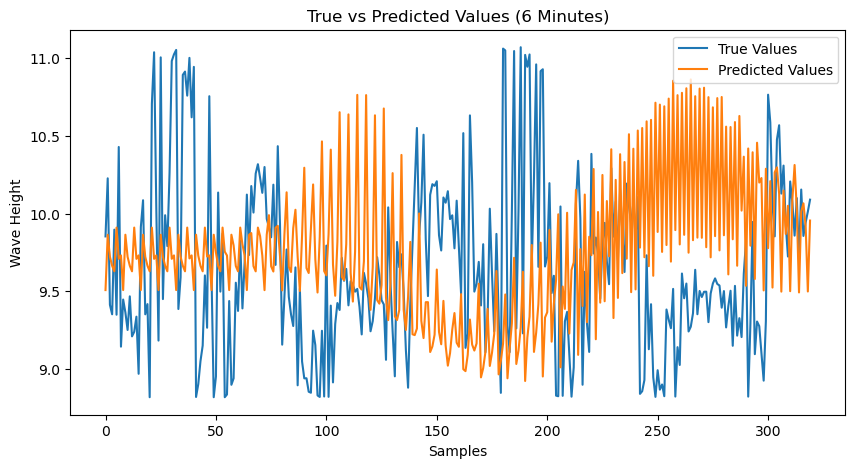

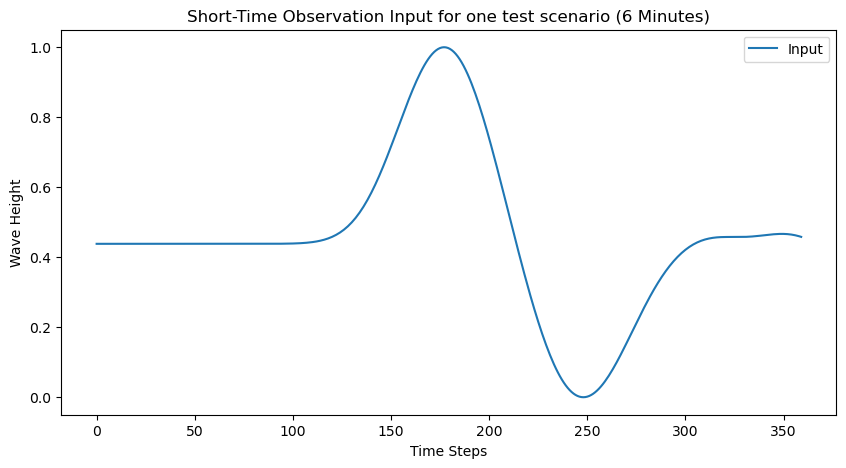

10/10 [==============================] - 0s 40ms/step
Duration: 7 minutes
MSE: 0.38956414703300635
MAE: 0.49877489755148324
R² Score: -0.8019712529301286


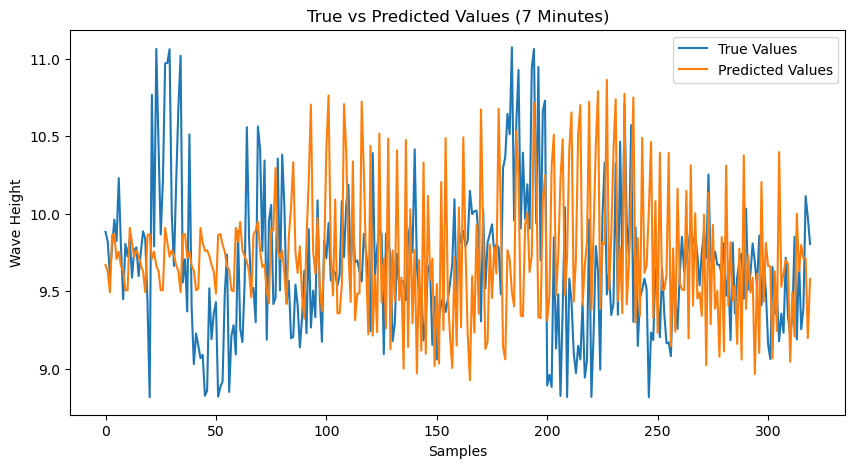

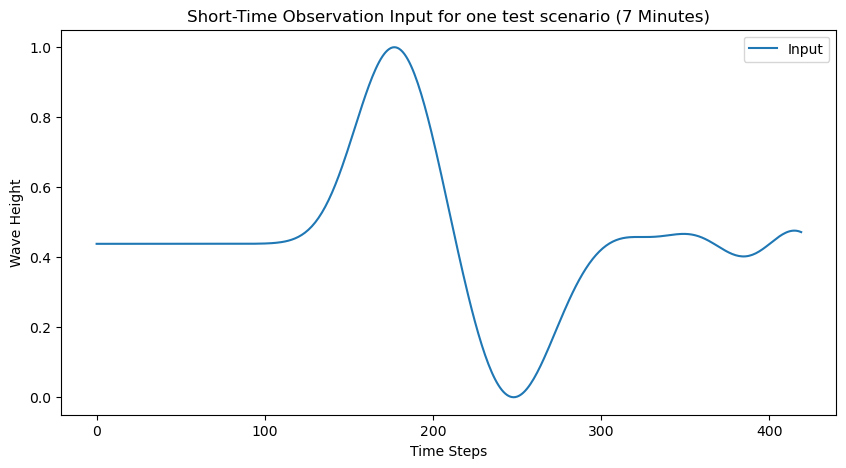

10/10 [==============================] - 0s 47ms/step
Duration: 8 minutes
MSE: 0.2854014122238096
MAE: 0.42893004632128173
R² Score: -0.463838739007171


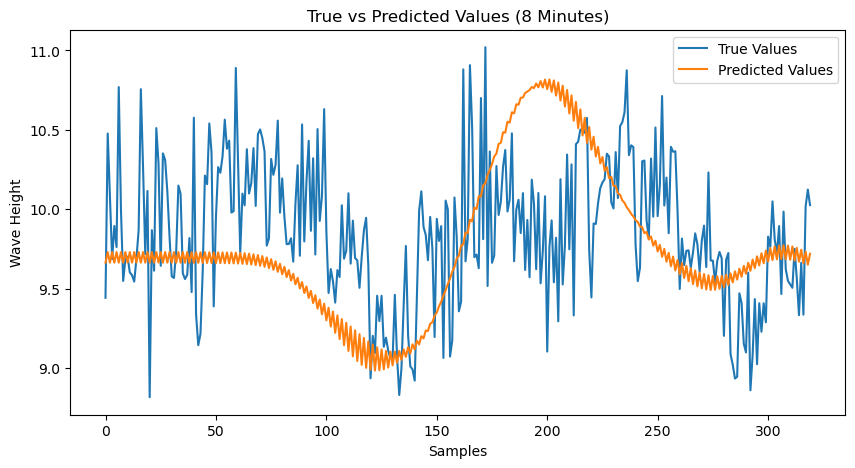

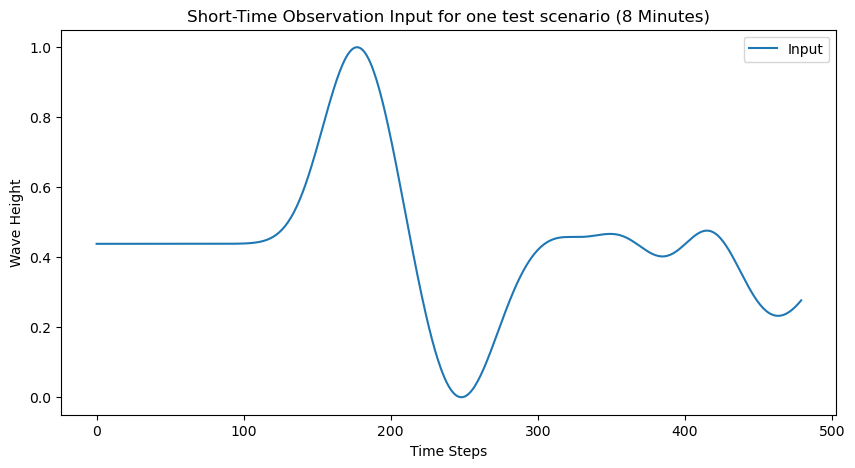

10/10 [==============================] - 1s 54ms/step
Duration: 9 minutes
MSE: 0.28639036880388863
MAE: 0.4173684498357967
R² Score: -1.2213293804871812


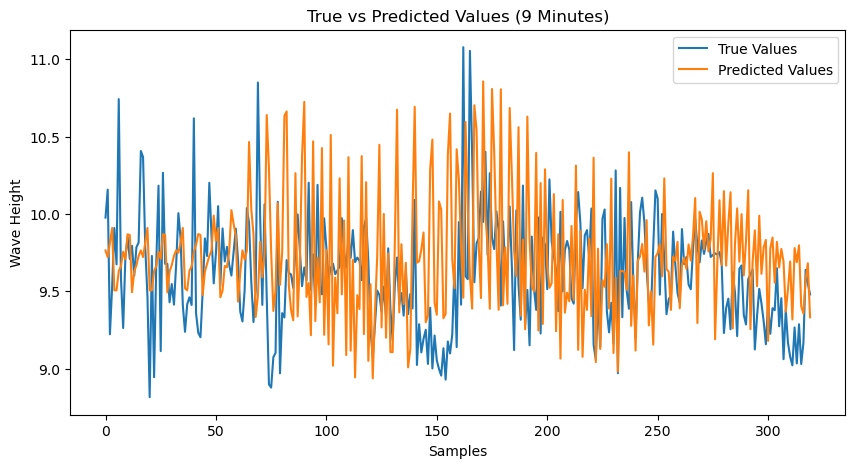

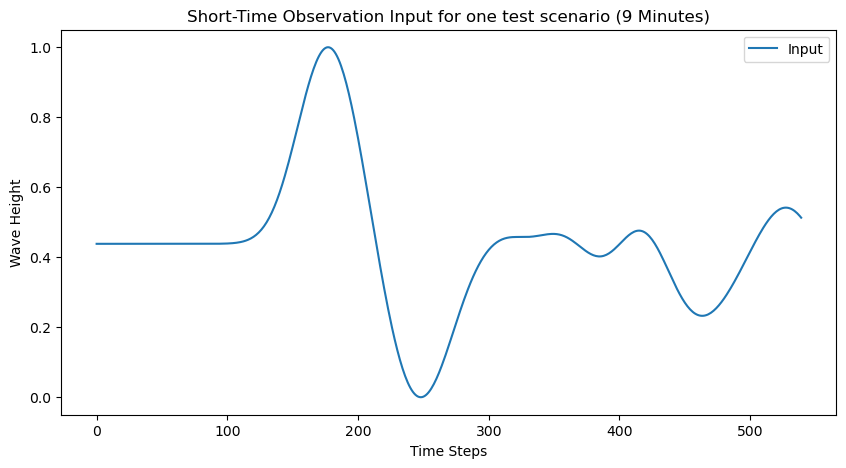

10/10 [==============================] - 1s 61ms/step
Duration: 10 minutes
MSE: 0.29735952343602373
MAE: 0.4252754163793201
R² Score: -0.975079926374105


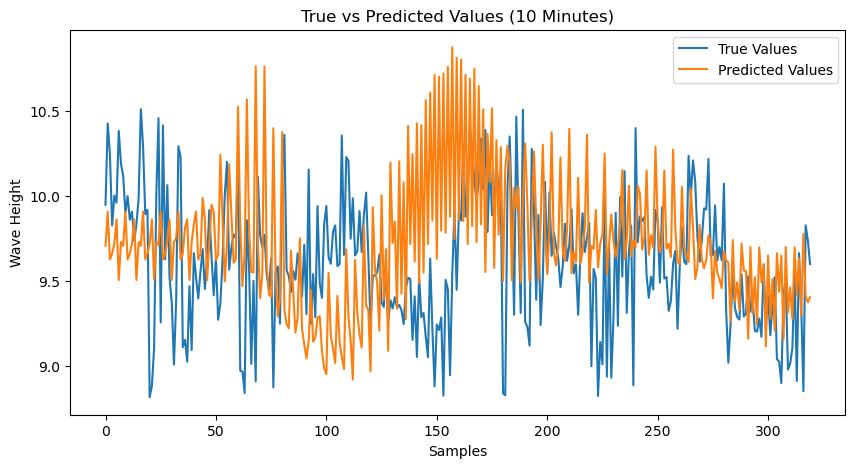

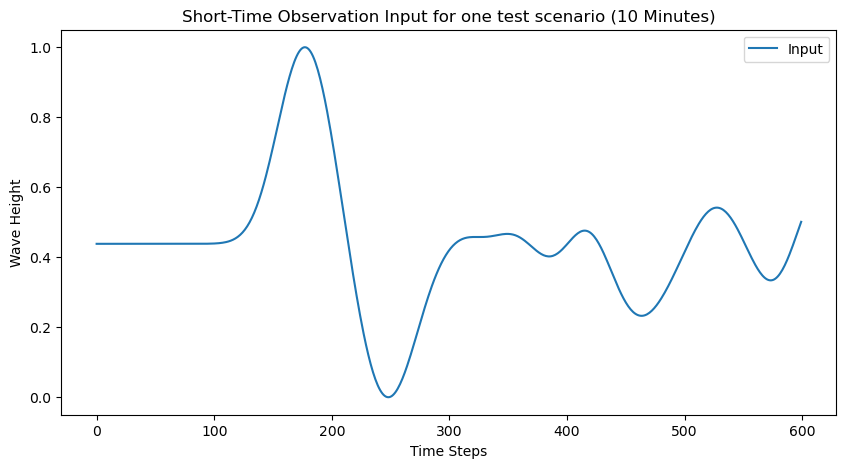

10/10 [==============================] - 1s 20ms/step
Duration: 1 minutes
MSE: 0.06723943592288023
MAE: 0.20598043255599535
R² Score: -0.37875042557068506


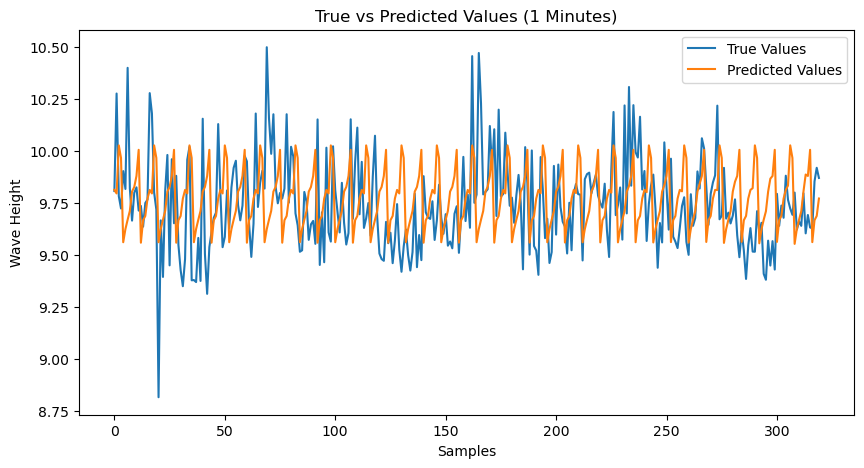

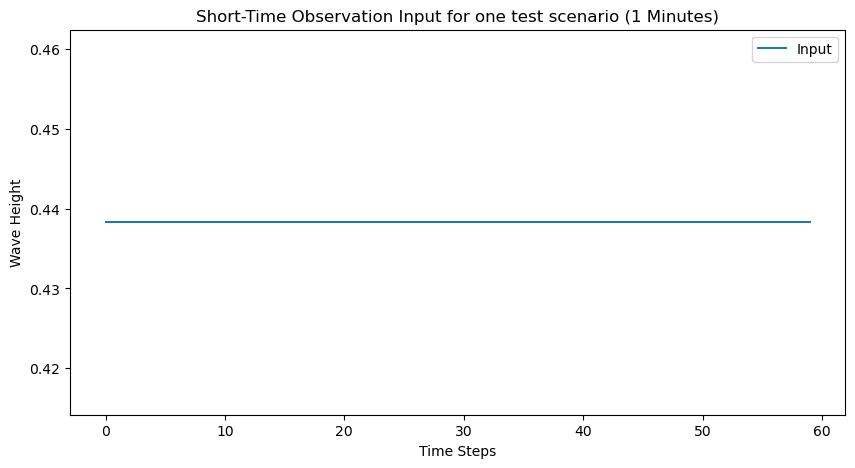

10/10 [==============================] - 0s 38ms/step
Duration: 2 minutes
MSE: 0.25811815946402306
MAE: 0.369532777894937
R² Score: -0.3396475305926867


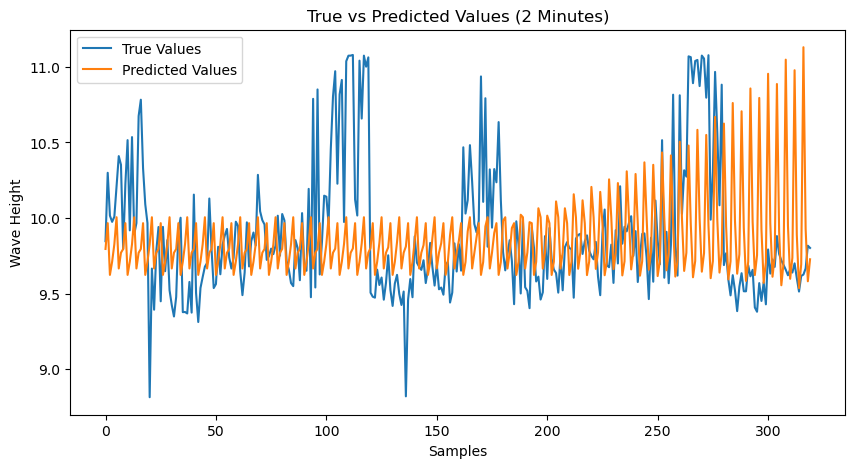

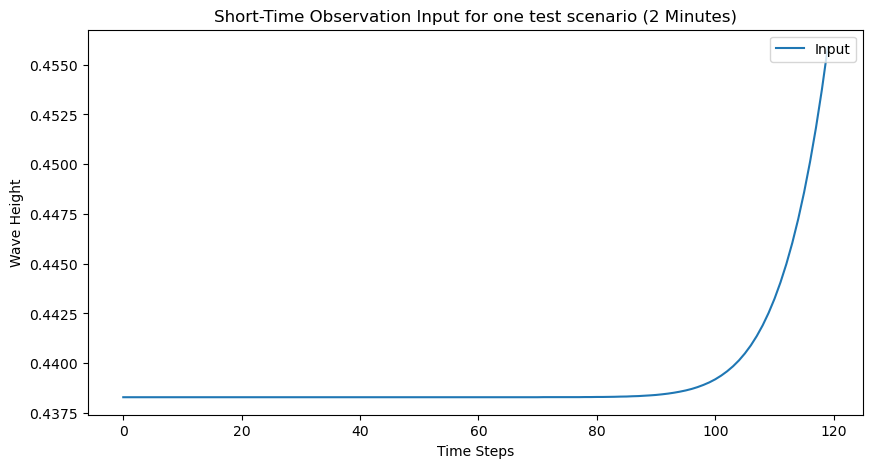

10/10 [==============================] - 1s 54ms/step
Duration: 3 minutes
MSE: 0.6310876098599746
MAE: 0.6310865774162793
R² Score: -0.3701126012747602


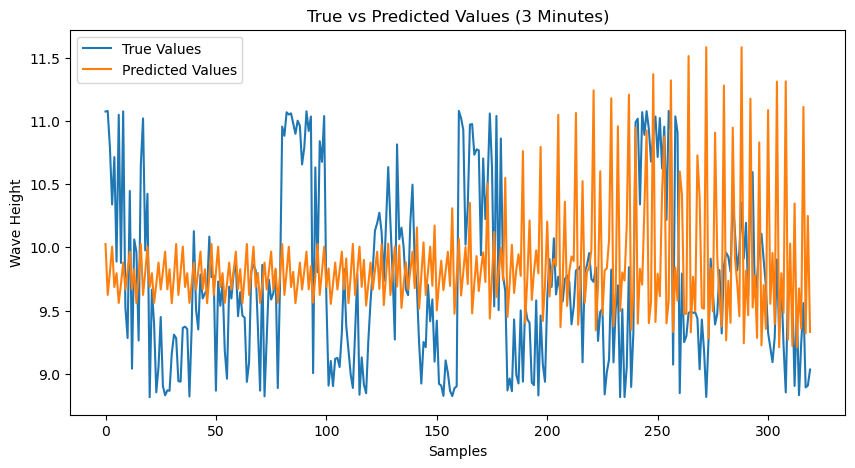

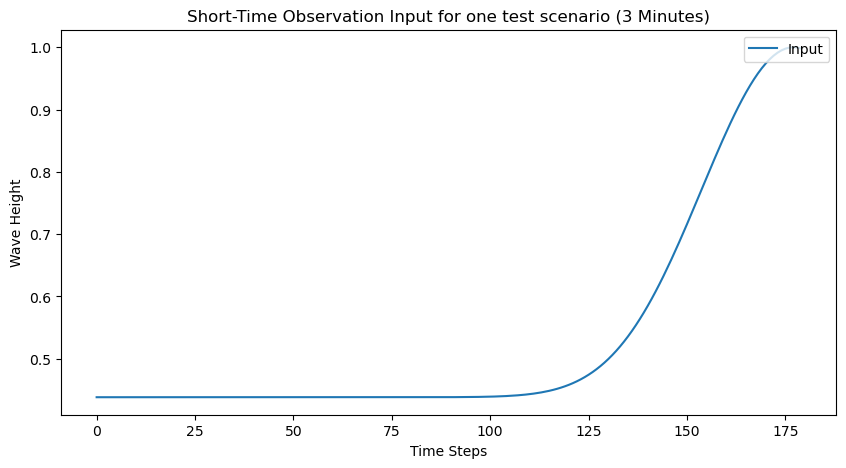

10/10 [==============================] - 1s 71ms/step
Duration: 4 minutes
MSE: 0.5776253403495922
MAE: 0.6306615524491189
R² Score: -0.19390044546386287


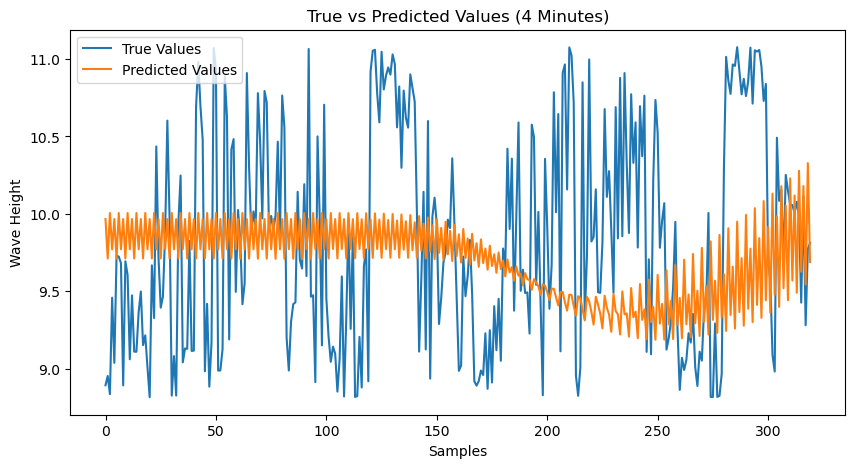

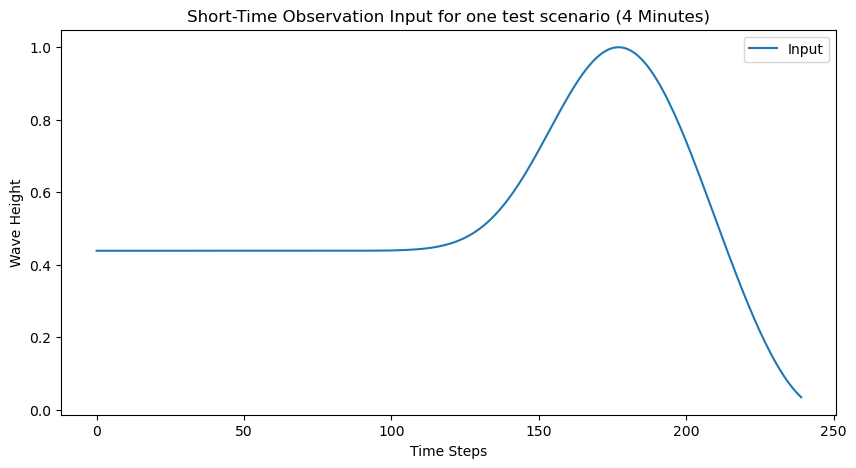

10/10 [==============================] - 1s 88ms/step
Duration: 5 minutes
MSE: 0.7422483260728195
MAE: 0.6796875411420427
R² Score: -0.8554791661623764


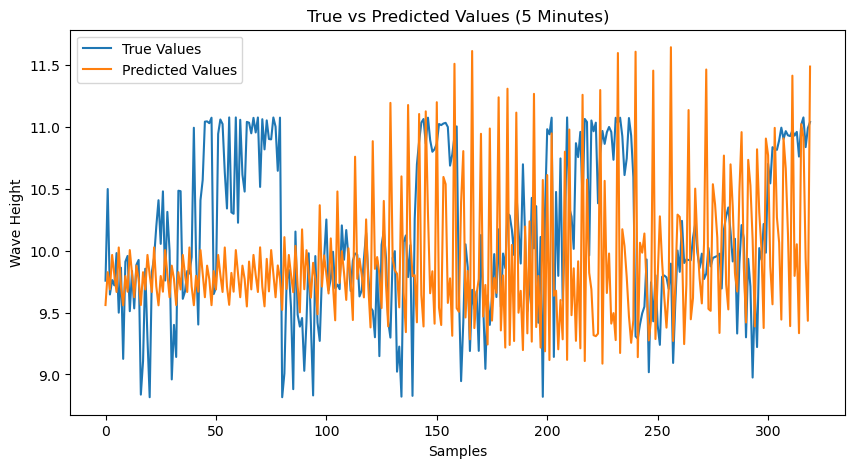

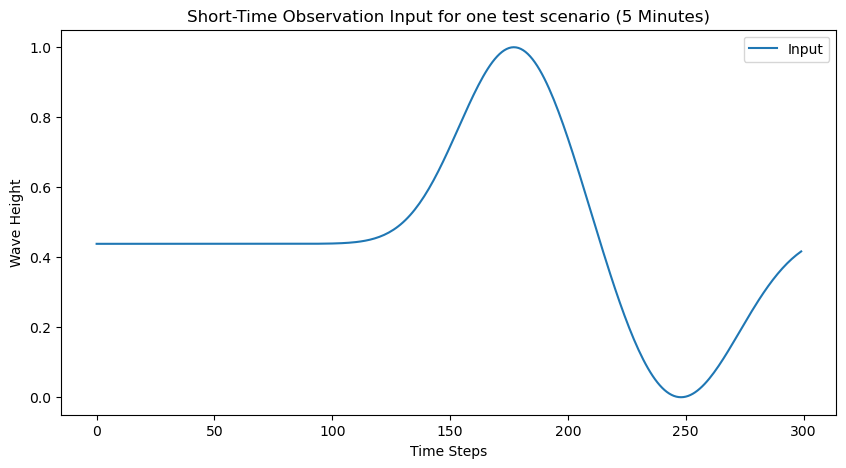

10/10 [==============================] - 1s 104ms/step
Duration: 6 minutes
MSE: 0.7735117931572766
MAE: 0.6946793236937436
R² Score: -1.4567825352396992


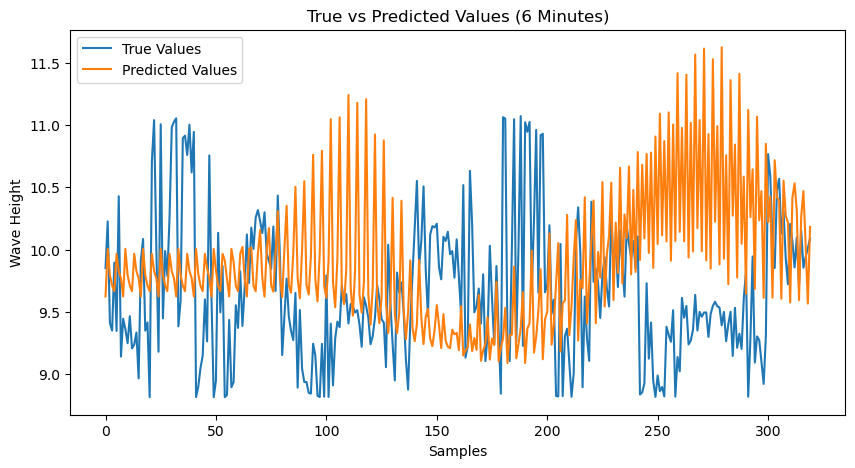

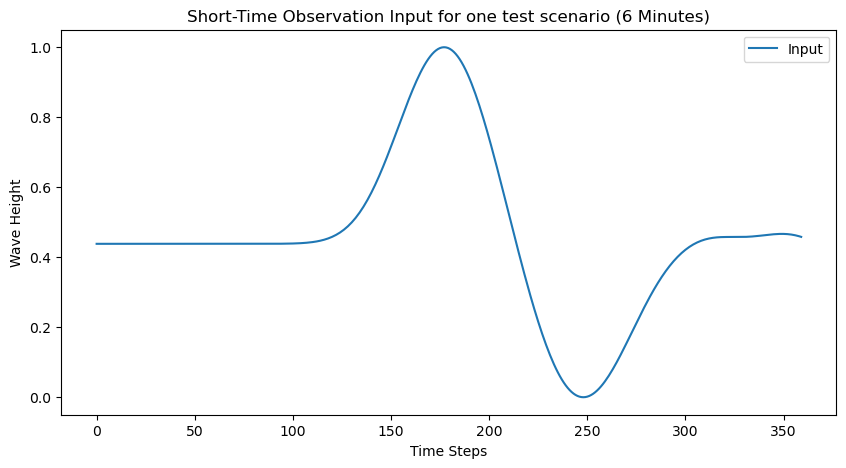

10/10 [==============================] - 1s 116ms/step
Duration: 7 minutes
MSE: 0.5825900091643511
MAE: 0.5812505579627067
R² Score: -1.6948333329799836


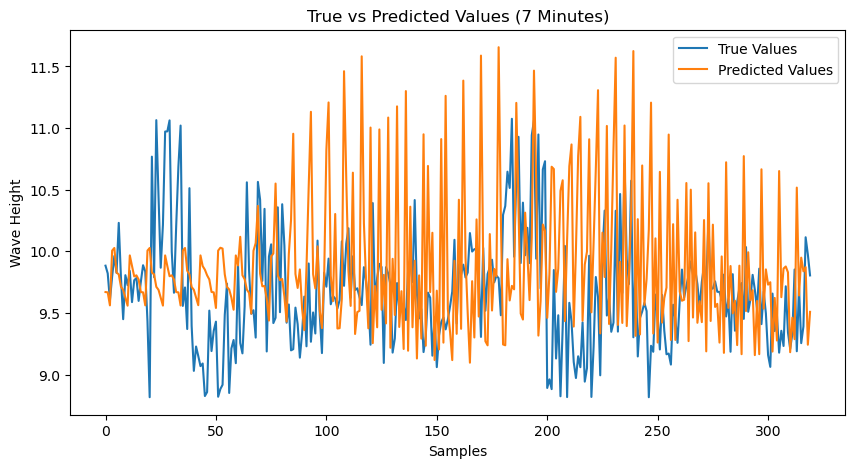

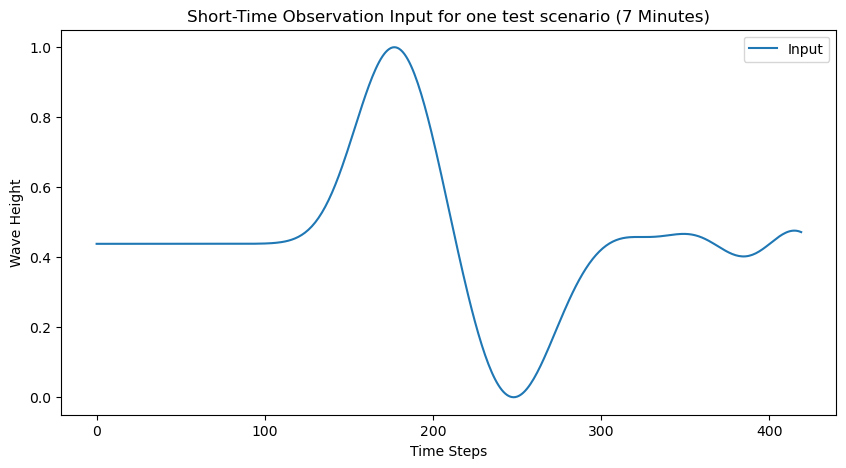

10/10 [==============================] - 1s 130ms/step
Duration: 8 minutes
MSE: 0.43853299541640267
MAE: 0.48994474195976034
R² Score: -1.2492586214674324


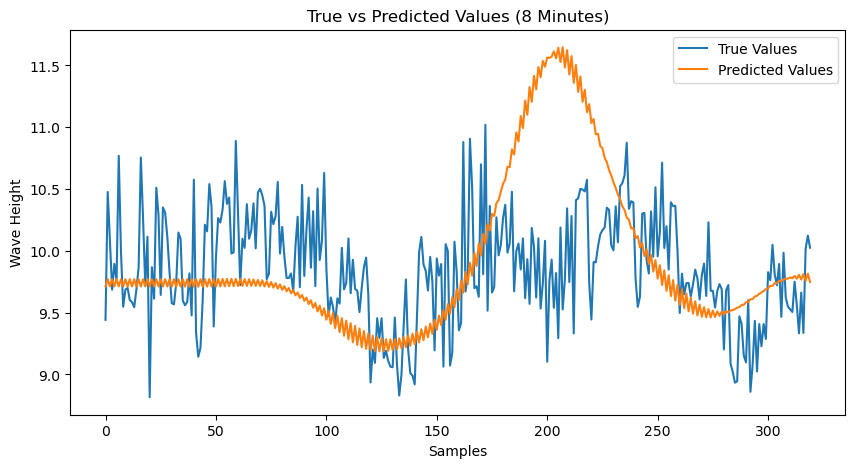

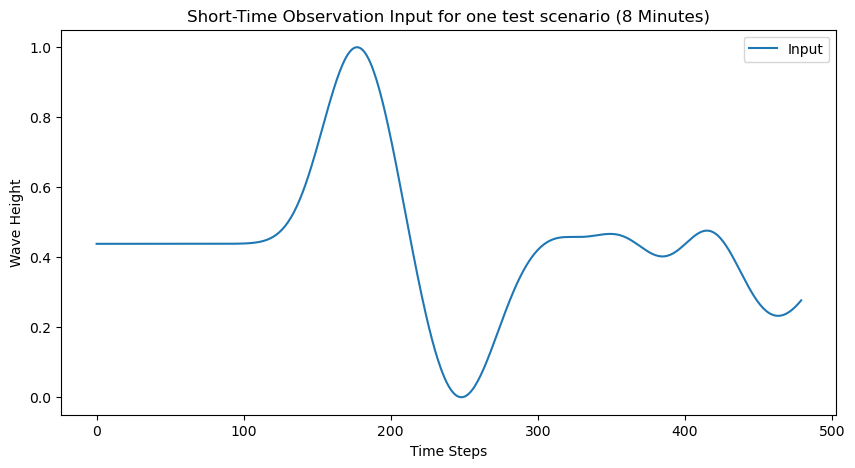

10/10 [==============================] - 1s 145ms/step
Duration: 9 minutes
MSE: 0.45186459630279874
MAE: 0.504655565378189
R² Score: -2.504796994261761


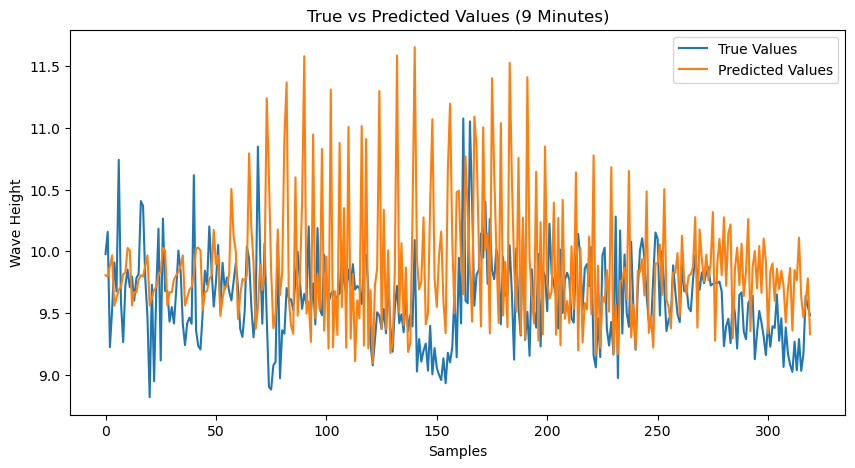

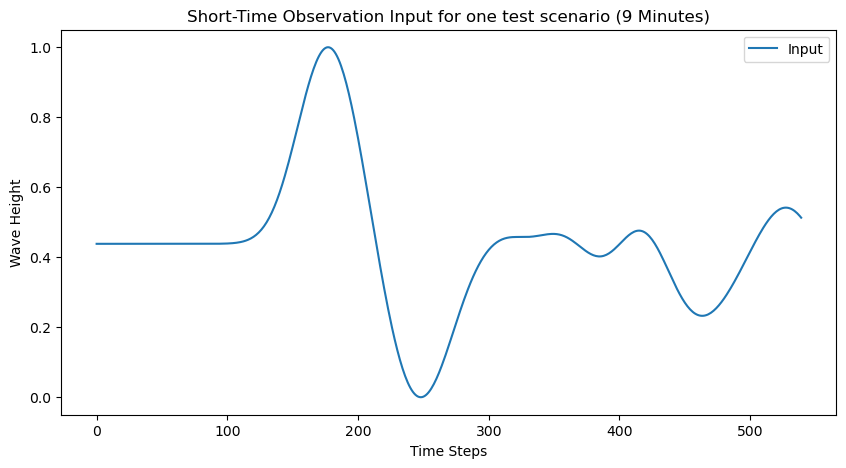

10/10 [==============================] - 2s 161ms/step
Duration: 10 minutes
MSE: 0.41960146954366806
MAE: 0.4908639236882576
R² Score: -1.7870183204375398


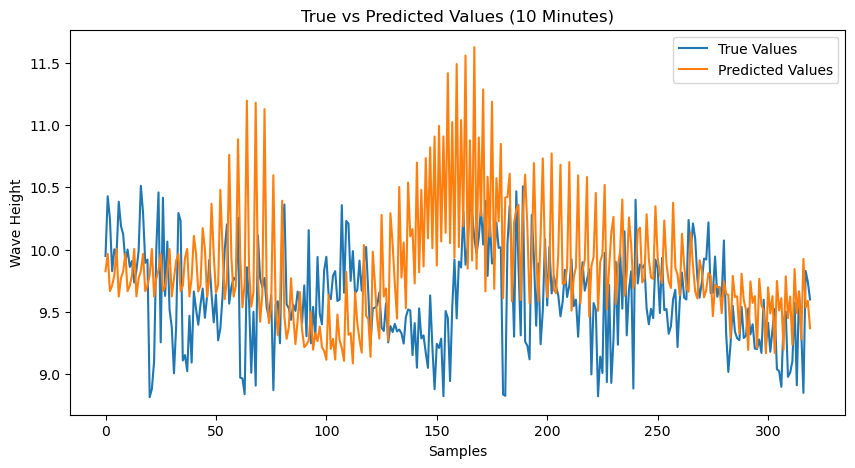

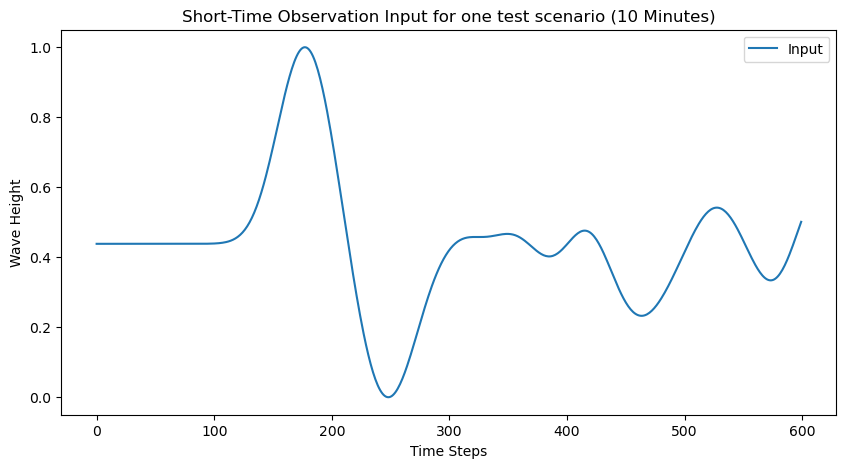

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import openpyxl

# Load data
data_path = "C:\\Users\\elmoe\\Desktop\\decision tree\\decision making\\sim3_rakata_6(320sc).xlsx"
df = pd.read_excel(data_path)

# Assuming first column is 'time' and the rest are the scenarios
time = df.iloc[:, 0].values
scenarios = df.iloc[:, 1:].values

# Normalize the scenarios
scalers = {}
normalized_scenarios = np.zeros_like(scenarios)
for i in range(scenarios.shape[1]):
    scalers[i] = MinMaxScaler()
    normalized_scenarios[:, i] = scalers[i].fit_transform(scenarios[:, i].reshape(-1, 1)).reshape(-1)

# Combine the time and normalized scenarios for further processing
data_normalized = np.column_stack((time, normalized_scenarios))

# Function to create sequences
def create_short_sequences(data, seq_lengths, time_interval):
    sequences = {}
    for length in seq_lengths:
        num_steps = length * time_interval  # Convert time to number of steps
        seq_data = []
        for col in range(1, data.shape[1]):  # Iterate over each scenario column
            seq = data[:num_steps, col]
            seq_data.append(seq)
        sequences[length] = np.array(seq_data)
    return sequences

# Assuming data is recorded every second
time_interval = 60  # in seconds (1 minute = 60 seconds)
seq_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # lengths in minutes

# Create sequences
short_sequences = create_short_sequences(data_normalized, seq_lengths, time_interval)

# Example using sequences of 5 minutes
seq_length = 5  # for example, we are using 5 minutes
X = short_sequences[seq_length][:, :-1]
y = short_sequences[seq_length][:, -1]

# Check for NaN values and remove them
X = np.nan_to_num(X)
y = np.nan_to_num(y)

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))  # Output layer for prediction
    model.compile(optimizer='adam', loss='mse')
    return model

# Build a more complex LSTM model
def build_complex_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for prediction
    model.compile(optimizer='adam', loss='mse')
    return model

# Define input shape
input_shape = (X_train.shape[1], 1)  # 29 timesteps, 1 feature per timestep

# Build and train the initial LSTM model
model = build_lstm_model(input_shape)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_val_reshaped, y_val))

# Build and train the complex LSTM model
complex_lstm_model = build_complex_lstm_model(input_shape)
history_complex_lstm = complex_lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_val_reshaped, y_val))

# Evaluate the models on the validation data
val_loss = model.evaluate(X_val_reshaped, y_val)
val_loss_complex_lstm = complex_lstm_model.evaluate(X_val_reshaped, y_val)
print(f'Validation Loss (LSTM): {val_loss}')
print(f'Validation Loss (Complex LSTM): {val_loss_complex_lstm}')

# Plot training & validation loss values for all models
plt.plot(history.history['loss'], label='LSTM Train Loss')
plt.plot(history.history['val_loss'], label='LSTM Val Loss')
plt.plot(history_complex_lstm.history['loss'], label='Complex LSTM Train Loss')
plt.plot(history_complex_lstm.history['val_loss'], label='Complex LSTM Val Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Make predictions and evaluate model performance
def evaluate_model(model, X_val_reshaped, y_val, scalers):
    y_pred = model.predict(X_val_reshaped).reshape(-1)
    y_val = y_val.reshape(-1)
    
    # Check for NaN values
    y_pred = np.nan_to_num(y_pred)
    y_val = np.nan_to_num(y_val)
    
    # Inverse transform predictions and true values to original scale
    y_pred_original = scalers[0].inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
    y_val_original = scalers[0].inverse_transform(y_val.reshape(-1, 1)).reshape(-1)
    
    mse = mean_squared_error(y_val_original, y_pred_original)
    mae = mean_absolute_error(y_val_original, y_pred_original)
    r2 = r2_score(y_val_original, y_pred_original)
    
    return mse, mae, r2, y_pred_original, y_val_original

mse, mae, r2, y_pred_original, y_val_original = evaluate_model(model, X_val_reshaped, y_val, scalers)
mse_complex_lstm, mae_complex_lstm, r2_complex_lstm, y_pred_complex_lstm, y_val_original_complex_lstm = evaluate_model(complex_lstm_model, X_val_reshaped, y_val, scalers)

print(f'LSTM - MSE: {mse}, MAE: {mae}, R² Score: {r2}')
print(f'Complex LSTM - MSE: {mse_complex_lstm}, MAE: {mae_complex_lstm}, R² Score: {r2_complex_lstm}')

# Plot true vs predicted values for comparison
plt.figure(figsize=(10, 5))
plt.plot(y_val_original, label='True Values')
plt.plot(y_pred_original, label='LSTM Predictions')
plt.plot(y_pred_complex_lstm, label='Complex LSTM Predictions')
plt.title('True vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Wave Height')
plt.legend()
plt.show()

# Save metrics to Excel
metrics_data = {
    'Model': ['LSTM', 'Complex LSTM'],
    'MSE': [mse, mse_complex_lstm],
    'MAE': [mae, mae_complex_lstm],
    'R² Score': [r2, r2_complex_lstm]
}
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_excel('model_comparison_metrics.xlsx', index=False)

# Function to test the model with short-time observations and save metrics to Excel
def test_short_time_observations_and_save(model, data_normalized, time_interval, short_durations, scalers, model_name):
    results = []
    for duration in short_durations:
        num_steps = duration * time_interval
        short_time_data = data_normalized[:num_steps, 1:]
        short_time_data_reshaped = short_time_data.reshape((short_time_data.shape[1], num_steps, 1))

        # Make predictions
        y_short_pred = model.predict(short_time_data_reshaped)
        y_short_pred = y_short_pred.reshape(-1)
        
        # Evaluate performance
        y_true = data_normalized[num_steps-1, 1:]
        
        # Check for NaN values
        y_short_pred = np.nan_to_num(y_short_pred)
        y_true = np.nan_to_num(y_true)
        
        # Inverse transform predictions and true values to original scale
        y_short_pred_original = scalers[0].inverse_transform(y_short_pred.reshape(-1, 1)).reshape(-1)
        y_true_original = scalers[0].inverse_transform(y_true.reshape(-1, 1)).reshape(-1)
        
        mse = mean_squared_error(y_true_original, y_short_pred_original)
        mae = mean_absolute_error(y_true_original, y_short_pred_original)
        r2 = r2_score(y_true_original, y_short_pred_original)

        print(f'Duration: {duration} minutes')
        print(f'MSE: {mse}')
        print(f'MAE: {mae}')
        print(f'R² Score: {r2}')
        
        results.append([duration, mse, mae, r2])
        
        # Plot true vs predicted values
        plt.figure(figsize=(10, 5))
        plt.plot(y_true_original, label='True Values')
        plt.plot(y_short_pred_original, label='Predicted Values')
        plt.title(f'True vs Predicted Values ({duration} Minutes)')
        plt.xlabel('Samples')
        plt.ylabel('Wave Height')
        plt.legend()
        plt.show()
        
        # Plot short-time observation input for one significant scenario
        plt.figure(figsize=(10, 5))
        plt.plot(short_time_data[:, 0], label=f'Input')
        plt.title(f'Short-Time Observation Input for one test scenario ({duration} Minutes)')
        plt.xlabel('Time Steps')
        plt.ylabel('Wave Height')
        plt.legend(loc='upper right')
        plt.show()
    
    results_df = pd.DataFrame(results, columns=['Duration (minutes)', 'MSE', 'MAE', 'R² Score'])
    results_df.to_excel(f'short_observations_{model_name}_metrics.xlsx', index=False)

# Test the model with short-time observations and save the results
test_short_time_observations_and_save(model, data_normalized, time_interval, seq_lengths, scalers, 'LSTM')
test_short_time_observations_and_save(complex_lstm_model, data_normalized, time_interval, seq_lengths, scalers, 'Complex_LSTM')

C:\Users\elmoe\AppData\Local\Temp\ipykernel_22720\68163671.py:48: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter([i], [df_mse['MSE'][i]], label=f'{df_mse["Model"][i]} MSE', marker=markers_mse[i], color=colors[i], s=200, edgecolors='k', linewidths=1.5)
C:\Users\elmoe\AppData\Local\Temp\ipykernel_22720\68163671.py:53: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter([i], [df_mae['MAE'][i]], label=f'{df_mae["Model"][i]} MAE', marker=markers_mae[i], color=colors[i], edgecolors='k', linewidths=1.5, s=200)


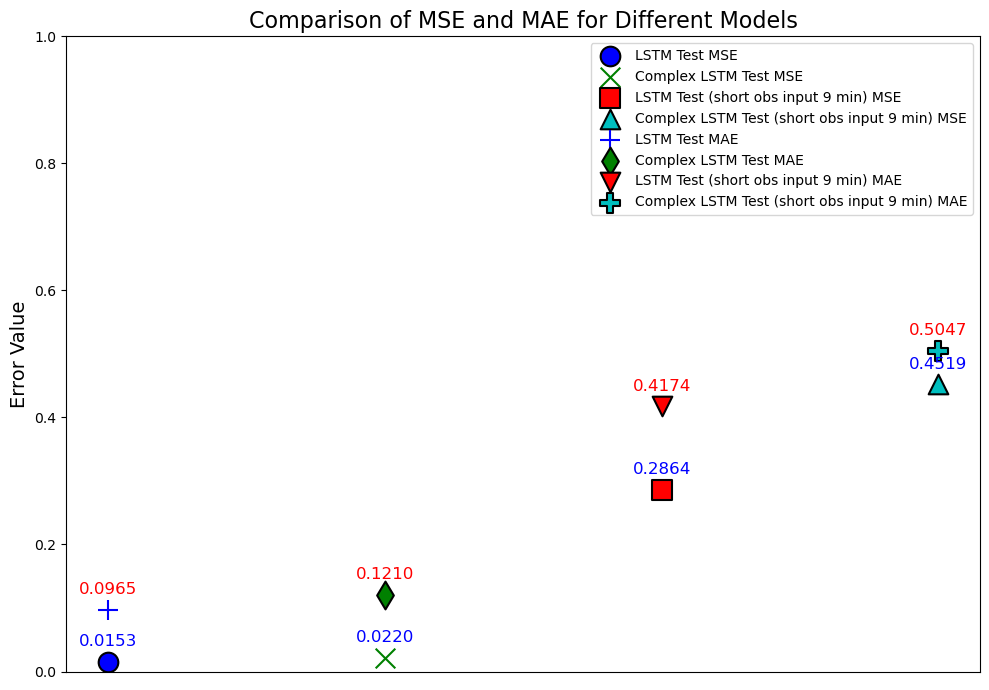

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Modified MSE and MAE data
data_mse = {
    'Model': [
        'LSTM Test', 
        'Complex LSTM Test', 
        'LSTM Test (short obs input 9 min)', 
        'Complex LSTM Test (short obs input 9 min)'
    ],
    'MSE': [
        0.015346824, 
        0.021991229, 
        0.286390369, 
        0.451864596
    ]
}

data_mae = {
    'Model': [
        'LSTM Test', 
        'Complex LSTM Test', 
        'LSTM Test (short obs input 9 min)', 
        'Complex LSTM Test (short obs input 9 min)'
    ],
    'MAE': [
        0.096541435, 
        0.120993311, 
        0.41736845, 
        0.504655565
    ]
}

df_mse = pd.DataFrame(data_mse)
df_mae = pd.DataFrame(data_mae)

# Define markers and colors for MSE and MAE
markers_mse = ['o', 'x', 's', '^']
markers_mae = ['+', 'd', 'v', 'P']
colors = ['b', 'g', 'r', 'c']  # Colors for both MSE and MAE

# Plotting both MSE and MAE in a single figure with enhanced visual elements
plt.figure(figsize=(10, 7))

# Plot MSE with labels
for i in range(len(df_mse)):
    plt.scatter([i], [df_mse['MSE'][i]], label=f'{df_mse["Model"][i]} MSE', marker=markers_mse[i], color=colors[i], s=200, edgecolors='k', linewidths=1.5)
    plt.text(i, df_mse['MSE'][i] + 0.02, f'{df_mse["MSE"][i]:.4f}', fontsize=12, va='bottom', ha='center', color='b')

# Plot MAE with labels
for i in range(len(df_mae)):
    plt.scatter([i], [df_mae['MAE'][i]], label=f'{df_mae["Model"][i]} MAE', marker=markers_mae[i], color=colors[i], edgecolors='k', linewidths=1.5, s=200)
    plt.text(i, df_mae['MAE'][i] + 0.02, f'{df_mae["MAE"][i]:.4f}', fontsize=12, va='bottom', ha='center', color='r')

# Adding labels and title with larger font size
plt.ylabel('Error Value', fontsize=14)
plt.title('Comparison of MSE and MAE for Different Models', fontsize=16)
plt.xticks([])  # Remove X-axis ticks and labels
plt.grid(False)  # Remove grid lines
plt.ylim(0, 1.0)  # Set y-axis limits from 0 to 1.0
plt.legend(fontsize=10, loc='upper right')  # Adjust legend font size and location
plt.tight_layout()

# Save the plot to the specified path
save_path = r"C:\Users\elmoe\Desktop\decision tree\decision making\320sc\evaluation\mse_mae_comparison.png"
plt.savefig(save_path)

plt.show()